<hr>

Libreta Jupyter del trabajo de investigación

**"Estimación de la evapotranspiración espacio-temporal en olivares (Olea europaea L.) usando imágenes satelitales, Región Tacna, Perú"**

Autor: José Luis Huanuqueño Murillo (JLHM)

Octubre, 2025

<div style="font-size: 0.85em; color: #aab7c4; margin-top: 10px;">
<b><i>Nota de atribución:</i></b> Este cuaderno se basa y adapta el trabajo original de 
Cesar Francisco Vilca Gamarra (2022) desarrollado para arroz en Lambayeque.  
Repositorio fuente: <a href="https://github.com/vilcagamarracf/Inv_arroz_METRIC" style="color:#6ec8d8;">https://github.com/vilcagamarracf/Inv_arroz_METRIC</a>
</div>

<hr>


## Selección de pixeles

**Referencia**
- Bhattarai, N., Quackenbush, L. J., Im, J., & Shaw, S. B. (2017). A new optimized algorithm for automating endmember pixel selection in the SEBAL and METRIC models. *Remote Sensing of Environment*, 196, 178-192. [10.1016/j.rse.2017.05.009](http://dx.doi.org/10.1016/j.rse.2017.05.009)

**Selección de pixeles fríos y calientes**

- In terms of identifying a cold pixel, the search method seeks to find
the coldest pixels with the highest NDVI. There is not necessarily one
pixel that has both the lowest Ts and the highest NDVI. Thus, instead
of searching for a single pixel, the method searches for a subset of pixels that have both low NDVI and high Ts.
- Specifically, the cold pixel selection process starts by searching for **pixels that have a Ts value within the lowest n1% (e.g. n1 = 1) of the Ts histogram** and NDVI values in
the top n2% (e.g. n2 = 1) of the NDVI histogram.
- The search continues by increasing the value of n2 first (i.e. increasing n2 in increments of 1 up to 10, keeping n1 = 1) and then increasing n1 (up to 10 in increments of 1) until 10 pixels are identified.

## Inicio

In [ ]:
# ==== Header de proyecto (importa módulos de /src y fija rutas) ====
import sys, os
from pathlib import Path

# 1) Detecta la raíz del proyecto buscando la carpeta 'src'
def find_project_root(start: Path, marker="src") -> Path:
    for p in [start, *start.parents]:
        if (p / marker).exists():
            return p
    return start  # fallback

CWD = Path.cwd()
BASE_DIR = find_project_root(CWD, "src")

# 2) Añade /src al path de Python (si no está)
SRC_DIR = BASE_DIR / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

In [2]:
# Ruta del directorio de trabajo
%pwd

'c:\\Users\\joluh\\OneDrive\\Thesis\\Articles\\Tacna\\Metric_Olive_21_22\\notebooks'

In [3]:
import os
os.chdir('c:\\Users\\joluh\\OneDrive\\Thesis\\Articles\\Tacna\\Metric_Olive_21_22\\notebooks')
os.getcwd()

'c:\\Users\\joluh\\OneDrive\\Thesis\\Articles\\Tacna\\Metric_Olive_21_22\\notebooks'

In [ ]:
# ==============================================================
# 🌎 GOOGLE EARTH ENGINE – Autenticación e inicialización del entorno
# ==============================================================

import ee
import geemap

# 1️⃣ AUTENTICACIÓN
# --------------------------------------------------------------
# Este paso abre un enlace en el navegador para iniciar sesión
# con tu cuenta de Google vinculada a Earth Engine.
# Solo necesitas hacerlo la primera vez o cuando el token expire.
ee.Authenticate(auth_mode='notebook')

# 2️⃣ INICIALIZACIÓN DEL ENTORNO
# --------------------------------------------------------------
# Se inicia la sesión usando el Project ID personal registrado en GEE.
# El parámetro 'project' identifica tu cuenta en el entorno de Google Cloud.
ee.Initialize(project='ee-joluhumu')

# 3️⃣ PRUEBA DE CONEXIÓN
# --------------------------------------------------------------
# Envía un mensaje simple al servidor de Earth Engine para verificar
# que la conexión y autenticación se realizaron correctamente.
print(ee.String('✅ Conexión establecida con los servidores de Earth Engine').getInfo())

# 4️⃣ OPCIONAL: Crear un mapa base interactivo (comentado por defecto)
# Map = geemap.Map()
# Map


Hello from the Earth Engine servers!


In [ ]:
# !pip install geopandas

In [5]:
# ------------------------------------------------
# Importando librerías utilizadas
# ------------------------------------------------

# import ee
# ee.Initialize()

import os
import numpy as np
import math
import pandas as pd
from pprint import pprint
import geopandas as gpd
import geemap
import geemap.colormaps as cmp # Paletas para visualización de imágenes

# Funciones en archivo Funciones.py
from funciones import *

In [5]:
# ------------------------------------------------------------------------------------------------
# Pruebas: En caso de realizar alguna edición al archivo 'funciones.py' realizar lo siguiente:
# ------------------------------------------------------------------------------------------------

# import importlib 
# import sys

# importlib.reload(sys.modules['funciones']) # Importa las funciones del archivo con las modificaciones aplicadas
# from funciones import *    

In [6]:
# # Importar asset público: Distrito de Ferreñafe
gdf = gpd.read_file("C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/raw/shapefiles/Olive_Plot.shp")
asset_dist = geemap.gdf_to_ee(gdf)

# # Filtrar el distrito "FERREÑAFE"
dist_fcol = asset_dist.filter(ee.Filter.eq('NOMBPROV', 'TACNA'))

# # Obtener el bounding box de su geometría
roi = dist_fcol.geometry().bounds()

In [7]:
display(gdf)

,Id,geometry
0,0,"POLYGON ((337597.296 7989327.23, 337795.586 79..."


In [8]:
roi = ee.FeatureCollection('projects/ee-joluhumu/assets/Olive_Plot')

In [9]:
# ------------------------------------------------
# Importando áreas de estudio
# ------------------------------------------------

# # # Importar asset público: Distrito de Ferreñafe (ejemplo comentado)
# asset_dist = ee.FeatureCollection('D:/2025/Olivo_Tacna/METRIC/METRIC_PRUEBA/SHP/Provincia_Ferreñafe.shp')
# dist_fcol   = asset_dist.filterMetadata('DISTRITO', 'equals', 'FERREÑAFE')
# roi         = dist_fcol.geometry().bounds()   # ee.Geometry tipo caja

# Importar shapefile de Áreas voladas (archivo en local)
ruta = r'C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/raw/shapefiles/Olive_Plot.shp'  # <— antes: ruta

# Lectura como FeatureCollection con geemap
predios_agricolas   = geemap.shp_to_ee(ruta)

# (Alternativa con asset GEE — ejemplo comentado)
# asset_path         = 'projects/ee-joluhumu/assets/Olivo'
# predios_agricolas  = ee.FeatureCollection(asset_path)

# Capas de visualización: bordes de predios y caja envolvente
predios_vis       = ee.Image().paint(predios_agricolas, 2, 2)  # Ver solo bordes (color=2, grosor=2)
predios_bound     = predios_agricolas.geometry().bounds()
predios_bound_vis = ee.Image().paint(predios_bound, 1, 1)      # Ver solo bordes (color=1, grosor=1)

type(predios_agricolas)  # comprobación rápida del tipo (debería ser ee.featurecollection.FeatureCollection)

# ------------------------------------------------
# Parámetros de visualización de mapas con geemap
# ------------------------------------------------

# Para imágenes Landsat 8 y 9 TOA (RGB natural)
vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']}

# Paletas de colores (hex) para distintos productos
albedo_cmap = ['68181f', 'd6604d', 'f9dbc7', 'd1e5f0', '2166ac', '053061']  # rango típico 0–0.5
ndvi_cmap   = ['ffffff', 'ce7e45', 'fad163', '74a909', '3a7405', '1a3b03']  # rango típico -0.2–1
ts_cmap     = ['fefccc', 'fbd976', 'f08c39', 'ea4a33', 'e43d32', '812026']  # 280–330 K (o ~6.85–56.85 °C)
rn_cmp      = ['560e0d', 'fd5903', 'fbfe04', '3aff01', '01feef', '0000fe', 'fd6dfd', 'ffffff']
rn_cmp_r    = ['ffffff', 'fd6dfd', '0000fe', '01feef', '3aff01', 'fbfe04', 'fd5903', '560e0d']  # invertida

# -------------------------------------------------------
# Parámetros de visualización de gráficas con matplotlib
# -------------------------------------------------------

plt.rcParams['font.family']     = 'serif'   # familia tipográfica por defecto para figuras
plt.rcParams['xtick.labelsize'] = 12        # tamaño de fuente para etiquetas del eje X
plt.rcParams['ytick.labelsize'] = 12        # tamaño de fuente para etiquetas del eje Y
plt.rcParams['axes.titlesize']  = 14        # tamaño de fuente para títulos de ejes
plt.rcParams['axes.labelsize']  = 12        # tamaño de fuente para etiquetas de ejes
plt.rcParams['figure.dpi']      = 72        # resolución base de la figura (se puede sobrescribir al guardar)


In [10]:
predios_vis

## Función 

In [11]:
roi = ee.FeatureCollection('projects/ee-joluhumu/assets/Olive_Plot')

In [12]:
def getRadiacionNeta(img_ee, roi, dem, lai_method, albedo_method, HR):

    """Obtener mapa de Radiación Neta

    Parametros
    ----------
    img_ee : ee.Image
    roi : ee.Geometry
    dem : ee.Image

    Retorna
    -------
    R_n : ee.Image
    img_sr_tasumi : ee.Image
    img_productos : ee.Image
    d2 : ee.Number
    doy : ee.Number
    """

    # =================================================================
    # Constantes
    # =================================================================
    
    # Factor de conversión de grados a radianes
    factor_rad = ee.Number(math.pi/180)

    # Fechas
    img_date = img_ee.date() # ee.Date
    doy = img_date.getRelative('day', 'year') # ee.Number
    fecha = img_date.format('YYYY-MM-dd').getInfo() # string

    # =================================================================
    # Procesamiento
    # =================================================================

    # Procesar imagen RAW a TOA
    img_toa = convert_RAW_to_TOA(img_ee).clip(roi) # ee.Image
    
    # Índices de vegetación (eq. 23, 19 y 18)
    img_ndvi = get_ndvi_L8(img_toa)
    
    
    # ==================== ELECCIÓN DEL MÉTODO (0–5) ====================
    if lai_method == 0:
        # SAVI L=0.1 -> LAI
        img_savi = get_savi_L8(img_toa, L=0.1).rename('SAVI')
        img_lai  = get_lai_L8(img_savi).rename('LAI')

    elif lai_method == 1:
        # SAVI L=0.5 -> LAI
        img_savi = get_savi_L8(img_toa, L=0.5).rename('SAVI')
        img_lai  = get_lai_L8(img_savi).rename('LAI')

    elif lai_method == 2:
        # NDVI lineal -> LAI (y definimos SAVI para poder exportarlo en img_productos)
        img_savi = get_savi_L8(img_toa, L=0.5).rename('SAVI')
        img_lai  = img_ndvi.multiply(2.1362).add(0.0869).rename('LAI')

    elif lai_method == 3:
        img_savi = get_savi_L8(img_toa) 
        img_lai = img_ndvi.expression('(2.3523*img_ndvi)**2 - 1.9013*img_ndvi + 1.7714', 
                                      {'img_ndvi': img_ndvi.select('NDVI')}
                                      ).rename('LAI') # Usando 30 datos
    elif lai_method == 4:
        # Regla por tramos sobre SAVI
        img_savi = get_savi_L8(img_toa, L=0.5).rename('SAVI')
        img_lai  = img_savi.where(img_savi.lte(0.817), img_savi.pow(3).multiply(11))
        img_lai  = img_lai.where(img_savi.gt(0.817), 6).rename('LAI')

    elif lai_method == 5:
        # MCARI2/OSAVI -> fPAR -> LAI (Beer–Lambert)
        # Cambia a 'SR_B5','SR_B4','SR_B3' si trabajas con Surface Reflectance
        img_savi = get_savi_L8(img_toa, L=0.5).rename('SAVI')  # para incluir SAVI en img_productos
        NIR   = img_toa.select('B5')
        RED   = img_toa.select('B4')
        GREEN = img_toa.select('B3')

        osavi = NIR.subtract(RED).divide(NIR.add(RED).add(0.16))
        mcari2 = img_toa.expression(
            '1.5*(2.5*(N-R) - 1.3*(N-G)) / sqrt(pow(2*N+1, 2) - (6*N - 5*sqrt(R)) - 0.5)',
            {'N': NIR, 'R': RED, 'G': GREEN}
        )
        idx = mcari2.divide(osavi.add(1e-6))  # MCARI2/OSAVI

        # Coefs iniciales (ajusta con tus datos si quieres subir/bajar LAI)
        a = 0.75
        b = 0.08
        k = 0.55  # k menor => LAI mayor (típico leñosos 0.3–0.6)

        fpar   = idx.multiply(a).add(b).clamp(0.01, 0.95)
        img_lai = fpar.expression('-log(1 - f)/k', {'f': fpar, 'k': k}).rename('LAI')

    elif lai_method == 6:
            # MCARI2/OSAVI -> fPAR -> LAI usando coef. del paper (ajuste tipo Q1)
            # fPAR ≈ 1.65 * (MCARI2/OSAVI) + 0.02 ; k ~ 0.45–0.55
            img_savi = get_savi_L8(img_toa, L=0.5).rename('SAVI')
            NIR, RED, GREEN = img_toa.select('B5'), img_toa.select('B4'), img_toa.select('B3')
            osavi = NIR.subtract(RED).divide(NIR.add(RED).add(0.16))
            mcari2 = img_toa.expression(
                '1.5*(2.5*(N-R) - 1.3*(N-G)) / sqrt(pow(2*N+1, 2) - (6*N - 5*sqrt(R)) - 0.5)',
                {'N': NIR, 'R': RED, 'G': GREEN}
            )
            idx   = mcari2.divide(osavi.add(1e-6))
            a, b, k = 1.65, 0.02, 0.50
            fpar   = idx.multiply(a).add(b).clamp(0.01, 0.95)
            img_lai = fpar.expression('-log(1 - f)/k', {'f': fpar, 'k': k}).rename('LAI')
            # Recorte razonable para olivar en seto:
            img_lai = img_lai.clamp(0, 3.5)
    else:
        raise ValueError(f"lai_method desconocido: {lai_method}")

    # Saneo físico único al final
    img_lai = img_lai.max(0).min(7).rename('LAI')
    #img_lai = img_lai.where(img_lai.lte(0), 0)
    
    # A partir del DEM: Pendiente y Aspect [rad]
    img_dem_clippped = dem.clip(roi)
    img_slopes = ee.Terrain.slope(img_dem_clippped) # grados
    img_slopes_rad = img_slopes.multiply(factor_rad)  # ee.Image, radianes 
        
    img_aspect = ee.Terrain.aspect(img_dem_clippped) # grados
    img_aspect_rad = img_aspect.multiply(factor_rad)  # ee.Image, radianes


    # Ángulos Declinación, Latitud y Horario [rad]
    angle_decl, latitud, angle_hra = get_decl_lat_hra(img_ee, roi, doy)


    # Parámetro: Emisividad e_0 (eq. 17)
    e_nb, e_0 = get_emisividades(img_ndvi, img_lai)

    # =================================================================
    # Parámetro: Radiación de onda corta entrante 
    # =================================================================
    
    # Requiere: t_sw, d2, cos_theta_rel 
    # t_sw requiere: P_air, w, cos_theta_hor
    # w requiere: e_s

    # 1. d2 INVERSE RELATIVE DISTANCE EARTH-SUN (eq. 9)
    d2 = ee.Number.expression('1/( 1+0.033*cos(doy*2*pi/365) )',
                              {'doy': doy, 'pi': math.pi})

    # 2. cos_theta_rel [rad] (eq. 7)
    cos_theta_rel = get_cos_theta(angle_decl, 
                                  latitud, 
                                  angle_hra, 
                                  img_slopes_rad, 
                                  img_aspect_rad)

    # 3. t_sw (eq. 4)
    # 3.1. P_air Atmospheric Pressure [kPa] (eq. 5)
    P_air = dem.expression('101.3*( (293-0.0065*z)/293 )**5.26', 
                           {'z': dem.select(0)}) # ee.Image

    # 3.2. cos_theta_hor (eq. 8)
    cos_theta_hor = get_cos_theta(angle_decl, 
                                  latitud, 
                                  angle_hra, 
                                  slope_rad=0, 
                                  aspect_rad=0)
    
    # 3.3. w Water in the atmosphere [mm]
    # 3.3.1. Temperatura de superficie (eq. 20)
    ts = get_surface_temp(img_toa, e_nb)      # [K]
    ts_c = ts.subtract(273.15).rename('Ts_c') # [°C]

    # 3.3.2. Near-surface vapor pressure ea [kPa]
    # Ojo temperatura se requiere en °C
    # e0_eq = '6.112*exp(17.67*t / (t + 243.5))' # https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf
    e0_eq = '0.6108*exp(17.27*t / (t + 237.3))' # FAO 56, Allen (2012) https://www.fao.org/3/x0490s/x0490s01.pdf
    e0 = ts_c.expression(e0_eq, {'t': ts_c.select('Ts_c')})
    ea = e0.multiply(HR/100).rename('vapor_pressure')

    # 3.3.3. Agua precipitable en la atmósfera w [mm] Garrison & Adler (1990)
    w = ea.expression('0.14*ea*P + 2.1', {'ea':ea, 'P':P_air}).rename('w')
    
    # 3.3.4. t_sw: broad-band atmospheric transmissivity (eq. 4), ASCE-EWRI (2005)
    t_sw = P_air.expression('''
                            0.35 + 0.627*exp(
                            - 0.00146*P_air/(Kt*cos_theta_hor) 
                            - 0.075*(W/cos_theta_hor)**0.4
                            )
                            ''',
                            {'P_air':P_air, 'Kt':1, 'cos_theta_hor':cos_theta_hor, 'W':w}
                            ).rename('t_sw')
    
    # Finalmente: R_s_incoming (eq. 3)
    R_s_in = cos_theta_rel.expression('1367*cos_theta_rel*t_sw/d2',
                                      {'cos_theta_rel':cos_theta_rel, 't_sw':t_sw, 'd2':d2}
                                      ).rename('R_s_in')

    # =================================================================
    # Parámetro: Radiación de onda larga entrante
    # =================================================================

    # ea: effective atmospheric emissivity (eq. 25)
    atm_emissivity_ea = t_sw.expression('0.85*(- log(t_sw))**0.09',
                                        {'t_sw': t_sw}
                                        ).rename('atm_emissivity_ea')

    # Finalmente: R_l_in (eq. 24)
    R_l_in = atm_emissivity_ea.multiply(5.67E-08).multiply(ts.pow(4)).rename('R_l_in')

    # =================================================================
    # Parámetro: Radiación de onda larga saliente (eq.  16)
    # =================================================================

    R_l_out = e_0.multiply(5.67E-08).multiply(ts.pow(4)).rename('R_l_out')

    # =================================================================
    # Parámetro: Albedo
    # =================================================================

    # Corrección atmosférica - Tasumi et al. (2007) (eqs. 10 - 14)
    img_sr_tasumi = convert_TOA_to_SR(img_toa, P_air, w, cos_theta_hor)

    # Albedo (eq. 15)
    img_albedo = get_albedo(img_sr_tasumi, albedo_method)

    # Radiación Neta (eq. 2)
    Rn = img_albedo.expression(
        '(1-albedo)*R_s_in + (R_l_in - R_l_out) - (1-e_0)*R_l_in',
        {'albedo':img_albedo,
         'R_s_in':R_s_in,
         'R_l_in':R_l_in,
         'R_l_out':R_l_out,
         'e_0':e_0}
         ).rename('R_n')

    img_Rn = Rn.addBands([R_s_in, R_l_in, R_l_out])

    # Juntar los parámetros obtenidos en una sola imagen
    img_productos = ee.Image([
        img_ndvi.select('NDVI'),
        img_savi.select('SAVI'),
        img_lai.select('LAI'),
        img_albedo,
        ts,
        ts_c,
        t_sw,
        e_0,
        e_nb,
        cos_theta_rel,
        cos_theta_hor,
        img_slopes,
        dem
        ])

    img_productos_dict = {
        'img_Rn': img_Rn,
        'img_SR': img_sr_tasumi,
        'img_toa': img_toa,
        'img_productos': img_productos,
        'd2': d2,
        'doy': doy,
        'fecha': fecha
    }
        
    return img_productos_dict

In [13]:
# =============================================================
# HR (Out Hum) ~10–11 AM para fechas Landsat — versión robusta
# =============================================================
import pandas as pd
from datetime import datetime
from pathlib import Path

# ---------- Config ----------
CSV_PATH = r"C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\data\raw\meteo\Data_Meteo_Tacna.csv"

lista_ids = [
    'LANDSAT/LC08/C02/T1/LC08_002073_20211126',
    'LANDSAT/LC09/C02/T1/LC09_002073_20211204',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220302',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220318',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220403',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220419',
    'LANDSAT/LC09/C02/T1/LC09_002073_20220427',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220505',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220708',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220724'
]

# ---------- Utilidades ----------
def leer_csv_robusto(path):
    """Intenta con separadores comunes y devuelve un DataFrame."""
    for sep in [",", ";", "\t", "|"]:
        try:
            df = pd.read_csv(path, sep=sep, low_memory=False, encoding_errors="ignore")
            if df.shape[1] >= 2:
                return df
        except Exception:
            continue
    # Último intento con configuración por defecto
    return pd.read_csv(path, low_memory=False, encoding_errors="ignore")

def detectar_columna_humedad(df):
    """Detecta columna de humedad por nombres típicos o substring 'hum'."""
    # Preferencia exacta
    for c in df.columns:
        if c.strip().lower() == "out hum":
            return c
    # Aliases frecuentes
    candidatos = {
        "hum","humidity","out_hum","outhum","humedad","humedad_relativa","rh","out rh",
        "out_hum%","hum%","humidity%","relative humidity","relative_humidity"
    }
    for c in df.columns:
        if c.strip().lower() in candidatos:
            return c
    # Fallback por substring
    for c in df.columns:
        if "hum" in c.strip().lower():
            return c
    raise KeyError("No se encontró una columna de humedad (ej. 'Out Hum', 'RH', 'Humidity', ...).")

def detectar_columnas_fecha_hora(df):
    """Devuelve (fecha_col, hora_col). Si hay una sola datetime, hora_col = None."""
    # Candidatos por nombre
    cand_fecha = {
        "date","fecha","day","fechahora","datetime","date/time","timestamp",
        "time stamp","local time","localtime","fecha/hora","fecha hora"
    }
    cand_hora = {"time","hora","hour"}

    fecha_col = None
    hora_col  = None

    for c in df.columns:
        if c.strip().lower() in cand_fecha:
            fecha_col = c
            break
    for c in df.columns:
        if c.strip().lower() in cand_hora:
            hora_col = c
            break

    if fecha_col is not None:
        return fecha_col, hora_col

    # Buscar una sola columna que parsee como datetime
    mejor_col = None
    mejor_ok = -1
    for c in df.columns:
        try:
            parsed = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
            ok = parsed.notna().sum()
            if ok > mejor_ok:
                mejor_ok = ok
                mejor_col = c
        except Exception:
            pass

    if mejor_col is None or mejor_ok <= 0:
        raise KeyError("No se pudo detectar columna de fecha/hora en el CSV.")
    return mejor_col, None

def combinar_fecha_hora(df, fecha_col, hora_col):
    """Crea __dt__ (datetime completo), y columnas auxiliares Date y Time."""
    if hora_col is not None:
        # Fecha y hora separadas
        df["_fecha"] = pd.to_datetime(df[fecha_col], errors="coerce", infer_datetime_format=True).dt.date

        def parse_time(val):
            try:
                t = pd.to_datetime(val, errors="coerce", infer_datetime_format=True)
                if pd.isna(t):
                    return None
                return t.time()
            except Exception:
                return None

        df["_hora"] = df[hora_col].apply(parse_time)
        df["__dt__"] = df.apply(
            lambda r: pd.Timestamp.combine(r["_fecha"], r["_hora"]) if (pd.notna(r["_fecha"]) and r["_hora"] is not None) else pd.NaT,
            axis=1
        )
    else:
        # Una sola columna con datetime completo
        full = pd.to_datetime(df[fecha_col], errors="coerce", infer_datetime_format=True)
        df["__dt__"] = full
        df["_fecha"] = full.dt.date
        df["_hora"]  = full.dt.time

    df["Date"] = pd.to_datetime(df["_fecha"], errors="coerce")
    df["Time"] = df["_hora"]
    return df

def id_to_date(id_str):
    """Extrae YYYYMMDD de un ID Landsat (independiente de /T1/ /TOA/ /TI/)."""
    base = id_str.split("/")[-1]      # p.ej. LC08_002073_20211126
    date_str = base.split("_")[-1]    # 20211126
    return datetime.strptime(date_str, "%Y%m%d").date()

def hr_10_11_am_para_fecha(df, fecha, hum_col):
    """
    Devuelve humedad para un día:
    1) 10:00–10:59   2) 11:00–11:59
    3) 09:00–12:59   4) 08:00–13:59
    5) cualquier hora del día (más cercano a 10:30)
    """
    day_rows = df[df["Date"].dt.date == fecha].copy()
    if day_rows.empty:
        return None

    ventanas = [
        (10, 10),   # 10:00–10:59
        (11, 11),   # 11:00–11:59
        (9, 12),    # 09:00–12:59
        (8, 13),    # 08:00–13:59
        (0, 23),    # cualquier hora del día
    ]
    for h0, h1 in ventanas:
        cand = day_rows[(day_rows["__dt__"].dt.hour >= h0) & (day_rows["__dt__"].dt.hour <= h1)]
        if not cand.empty:
            target = pd.Timestamp.combine(pd.Timestamp(fecha), pd.Timestamp("10:30").time())
            idx = (cand["__dt__"] - target).abs().idxmin()
            val = cand.loc[idx, hum_col]
            try:
                return float(val)
            except Exception:
                return None
    return None

# ---------- Flujo ----------
# 1) Leer CSV
df = leer_csv_robusto(CSV_PATH)

# 2) Detectar columnas clave
hum_col = detectar_columna_humedad(df)
fecha_col, hora_col = detectar_columnas_fecha_hora(df)

# 3) Unificar datetime y limpiar humedad
df = combinar_fecha_hora(df, fecha_col, hora_col)
df = df[pd.notna(df["__dt__"]) & pd.notna(df[hum_col])].copy()
df[hum_col] = pd.to_numeric(df[hum_col], errors="coerce")
df = df[pd.notna(df[hum_col])].copy()

# 4) Fechas desde IDs Landsat
fechas = [id_to_date(i.replace("/LO09_", "/LC09_")) for i in lista_ids]

# 5) Calcular HR por fecha (~10–11 AM, con ventanas de respaldo)
HR = []
faltan = []
for f in fechas:
    v = hr_10_11_am_para_fecha(df, f, hum_col)
    if v is None:
        HR.append(None)
        faltan.append(f)
    else:
        HR.append(round(v, 2))

# 6) Mostrar resultados
for f, h in zip(fechas, HR):
    print(f"{f} → HR = {h}")

if faltan:
    print("\n⚠️ Fechas SIN datos útiles en el CSV (no se pudo estimar HR):")
    for f in faltan:
        print(" -", f)

print("\nHR =", HR)

# (Opcional) Exportar tabla resultado
# out = pd.DataFrame({"Fecha": fechas, "HR_10_11": HR})
# out.to_csv("hr_10_11_landsat.csv", index=False, encoding="utf-8-sig")
# print("\nArchivo guardado: hr_10_11_landsat.csv")


C:\Users\joluh\AppData\Local\Temp\ipykernel_45584\1630338812.py:120: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  full = pd.to_datetime(df[fecha_col], errors="coerce", infer_datetime_format=True)


2021-11-26 → HR = 60.0
2021-12-04 → HR = 61.0
2022-03-02 → HR = 57.0
2022-03-18 → HR = 66.0
2022-04-03 → HR = 61.0
2022-04-19 → HR = 63.0
2022-04-27 → HR = 71.0
2022-05-05 → HR = 65.0
2022-07-08 → HR = 72.0
2022-07-24 → HR = 76.0

HR = [60.0, 61.0, 57.0, 66.0, 61.0, 63.0, 71.0, 65.0, 72.0, 76.0]


In [14]:
roi = ee.FeatureCollection('projects/ee-joluhumu/assets/Olive_Plot')

## Procesamiento

In [15]:
# =============================================================
# Parámetros de visualización de mapas con geemap
# =============================================================

# Diccionario de visualización de imágenes Landsat 8 y 9 TOA
vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']} 

# Paletas de colores
albedo_cmap = ['68181f', 'd6604d', 'f9dbc7', 'd1e5f0', '2166ac', '053061'] # 0 - 0.5
ndvi_cmap = ['ffffff', 'ce7e45', 'fad163', '74a909', '3a7405', '1a3b03'] # -0.2 - 1  '0048fb',
ts_cmap = ['fefccc', 'fbd976', 'f08c39', 'ea4a33', 'e43d32', '812026'] # 280 - 330 en K o 6.85 - 56.85 en °C
rn_cmp = ['560e0d', 'fd5903', 'fbfe04', '3aff01', '01feef', '0000fe', 'fd6dfd', 'ffffff']
rn_cmp_r = ['ffffff', 'fd6dfd', '0000fe', '01feef', '3aff01', 'fbfe04', 'fd5903', '560e0d']

# =============================================================
# Inputs iniciales
# =============================================================

# Datos
# 2 de Diciembre 2021: Almácigo
# 4 de Enero 2022: Transplante

# 8 Imágenes Landsat seleccionadas

lista_ids = [
    'LANDSAT/LC08/C02/T1/LC08_002073_20211126',
    'LANDSAT/LC09/C02/T1/LC09_002073_20211204',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220302',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220318',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220403',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220419',
    'LANDSAT/LC09/C02/T1/LC09_002073_20220427',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220505',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220708',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220724'
]


# DEM SRTM 
# Ojo: El mapa Aspect no se puede obtener en los límites -> usar áreas mayores al área de estudio


dem = ee.Image("USGS/SRTMGL1_003").clip(roi)

# =============================================================
# Procesar las imagenes e incluirlos en una lista
# =============================================================

# Asignar método de estimación de LAI
# 0: Savi con l=0.1 
# 1: Savi con L=0.5 
# 2: Relación lineal NDVI - IAF: 2.1362*NDVI + 0.0869
# 3: Relación cuadrada NDVI - IAF : 2.3523*NDVI^2 - 1.9013*NDVI + 1.7714
lai_method = 2
albedo_method = '0.254*B2 + 0.149*B3 + 0.147*B4 + 0.311*B5 + 0.103*B6 + 0.036*B7'


HR = [60, 
      61, 
      57, 
      66, 
      61, 
      63, 
      71, 
      65, 
      72, 
      76
]


# Lista en blanco que va a contener los resultados
lista_imgprocesadas = []

for index, img_id in enumerate(lista_ids):

    # Imagen Landsat mediante ID
    img_ee = ee.Image(img_id).clip(roi)

    # Procesar Radiación Neta (produce un dict)
    img_procesada_dict = getRadiacionNeta(img_ee, predios_bound, dem,
                                          lai_method, albedo_method, HR[index]) # roi: Ferreñafe

    # Recorte por regiones
    img_procesada_dict['img_productos'] = img_procesada_dict['img_productos'].clip(predios_agricolas) 
    img_procesada_dict['img_toa'] = img_procesada_dict['img_toa']

    # Agregar a lista en blanco
    lista_imgprocesadas.append(img_procesada_dict)

    print(f"Productos y Rn de imagen {img_procesada_dict['fecha']} procesada! lai_method = {lai_method}")

n_imgs = len(lista_imgprocesadas)

Productos y Rn de imagen 2021-11-26 procesada! lai_method = 2
Productos y Rn de imagen 2021-12-04 procesada! lai_method = 2
Productos y Rn de imagen 2022-03-02 procesada! lai_method = 2
Productos y Rn de imagen 2022-03-18 procesada! lai_method = 2
Productos y Rn de imagen 2022-04-03 procesada! lai_method = 2
Productos y Rn de imagen 2022-04-19 procesada! lai_method = 2
Productos y Rn de imagen 2022-04-27 procesada! lai_method = 2
Productos y Rn de imagen 2022-05-05 procesada! lai_method = 2
Productos y Rn de imagen 2022-07-08 procesada! lai_method = 2
Productos y Rn de imagen 2022-07-24 procesada! lai_method = 2


## Prueba

In [16]:
# 0 - 01/13
# 1 - 01/29
# 2 - 03/10
# 3 - 04/03
# 4 - 05/05
# 5 - 05/21
# 6 - 06/14

index = 4

img_productos = lista_imgprocesadas[index]['img_productos']
img_rgb = lista_imgprocesadas[index]['img_toa'] 
img_sr = lista_imgprocesadas[index]['img_SR'] 

fecha = lista_imgprocesadas[index]['fecha']
print(fecha)

d2 = lista_imgprocesadas[index]['d2']
img_ndvi = img_productos.select('NDVI')
img_savi = img_productos.select('SAVI')
img_lai  = img_productos.select('LAI')
img_albedo = img_productos.select('albedo')
img_tempC = img_productos.select('Ts_c')
img_tempK = img_productos.select('Ts_k')
img_slope = img_productos.select('slope')

cos_theta_rel = img_productos.select('cos_theta')
t_sw = img_productos.select('t_sw')
e_0  = img_productos.select('e_0')

# Estadísticas
img_productos_dict = get_stats(img_productos, predios_agricolas, 30)
img_productos_df = pd.DataFrame.from_dict(img_productos_dict, orient='index') # .round(3)
display(img_productos_df[['NDVI',  'SAVI', 'LAI', 'albedo', 'Ts_k', 
                          'Ts_c', 't_sw', 'e_0', 'e_NB', 'cos_theta', 
                          'cos_theta_1', 'slope', 'elevation']])

vis_params_ndvi = {
    'min': -0.2, # img_productos_dict['min']['NDVI'],
    'max': 1,    # img_productos_dict['max']['NDVI'],
    'palette': ndvi_cmap # cmp.get_palette('RdYlGn')
}

vis_params_savi = {
    'min': img_productos_dict['min']['SAVI'],
    'max': img_productos_dict['max']['SAVI'],
    'palette': ndvi_cmap # cmp.get_palette('RdYlGn')
}

vis_params_alb = {
    'min': 0,
    'max': 0.25,
    'palette': ndvi_cmap#cmp.get_palette('gray') 
}

vis_params_ts = {
    'min': img_productos_dict['min']['Ts_c'],
    'max': img_productos_dict['max']['Ts_c'],
    'palette':cmp.get_palette('RdYlBu_r')
}
# 
vis_params_lai = {
    'min': 0,  
    'max': img_productos_dict['max']['LAI'], 
    'palette': cmp.get_palette('cubehelix_r') # RdYlGn_r, afmhot, turbo_r
}

# Después del filtrado de valores negativos de LAI

2022-04-03


,NDVI,SAVI,LAI,albedo,Ts_k,Ts_c,t_sw,e_0,e_NB,cos_theta,cos_theta_1,slope,elevation
max,0.438710,0.285294,1.024073,0.315486,312.794950,39.644950,0.702078,0.960241,0.973379,0.872423,0.787818,10.366290,53.000000
mean,0.282824,0.197338,0.691069,0.222046,310.415798,37.265798,0.693366,0.956911,0.972281,0.791336,0.787803,2.930373,46.775591
median,0.329235,0.228633,0.789684,0.213294,310.449552,37.296861,0.693292,0.957897,0.972607,0.790886,0.787803,2.926155,47.000000
min,0.062630,0.045413,0.220690,0.167291,307.469210,34.319210,0.686236,0.952207,0.970728,0.724046,0.787789,0.000000,41.000000
mode,0.342631,0.241592,0.818065,0.206634,309.237258,36.764866,0.692695,0.958888,0.972936,0.779006,0.787791,2.095249,47.000000
stdDev,0.106933,0.070715,0.228431,0.028034,1.174076,1.174076,0.003498,0.002284,0.000754,0.025752,0.000007,1.604637,1.988360


### Revisando datos

In [12]:
# Antes del filtrado de valores negativos de LAI

In [17]:
fecha

'2022-04-03'

In [ ]:
# pip install -U geemap earthengine-api
# pip install -U geemap

In [18]:
import math
import os

import ee

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
# =============================
#  CONFIGURACIÓN FIJA DE ESTILO
# =============================
mpl.rcParams.update({
    "figure.facecolor": "white",      # fondo de figura
    "axes.facecolor": "white",        # fondo del eje
    "savefig.facecolor": "white",     # fondo al guardar
    "text.color": "black",            # texto negro
    "axes.labelcolor": "black",       # etiquetas negras
    "xtick.color": "black",           # ejes x negros
    "ytick.color": "black",           # ejes y negros
    "axes.edgecolor": "black",        # bordes de ejes negros
    "axes.titlecolor": "black",       # título negro
})

import numpy as np

from geemap import cartoee

In [19]:
import ee
ee.Initialize()

# Geometría del ROI real
roi_fc = ee.FeatureCollection('projects/ee-joluhumu/assets/Olive_Plot')
roi    = roi_fc.geometry()

# BBOX correcto (oeste, sur, este, norte) con pequeño acolchonado
extent = 0.0005
bbox   = roi.bounds(1)
coords = ee.List(bbox.coordinates().get(0))
ws     = ee.List(coords.get(0))  # [west, south]
en     = ee.List(coords.get(2))  # [east, north]

west  = ee.Number(ws.get(0)).getInfo()
south = ee.Number(ws.get(1)).getInfo()
east  = ee.Number(en.get(0)).getInfo()
north = ee.Number(en.get(1)).getInfo()

zoom_region = [west - extent, south - extent, east + extent, north + extent]
print("zoom_region:", zoom_region)


zoom_region: [-70.53599729519621, -18.186253830061677, -70.5281854986762, -18.176982766042563]


In [20]:
predios_bound.coordinates().getInfo()

[[[-70.53549733279294, -18.185753980279564],
  [-70.52868765636423, -18.185753980279564],
  [-70.52868765636423, -18.17748074468125],
  [-70.53549733279294, -18.17748074468125],
  [-70.53549733279294, -18.185753980279564]]]

In [28]:
# ==========================================
# 📦 IMPORTS REQUERIDOS
# ==========================================
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
from geemap import cartoee

# Ajuste global: guardar a 600 dpi
mpl.rcParams['savefig.dpi'] = 600


# ==========================================
# 🎨 FUNCIÓN PRINCIPAL
# ==========================================
def get_grafica_cartoee_color(image, 
                              vis_params,                              
                              text=None, 
                              title_map=None,
                              label=None, 
                              save_fig=None,
                              nogrid=None):
    """
    Genera una figura con cartoee y guarda automáticamente a 600 dpi.
    - Usa zoom_region definido para el ROI.
    - Añade barra de escala y colorbar personalizada.
    - Guarda figuras en: figs/processed/LAI/
    """

    # =============================
    # 1️⃣ Área de visualización
    # =============================
    extent = 0.0004
    zoom_region = [
        -70.53539711730724 - extent,   # west
        -18.185505011017327 - extent,  # south
        -70.52796183246036 + extent,   # east
        -18.177618129602468 + extent   # north
    ]
    
    # =============================
    # 2️⃣ Crear figura
    # =============================
    fig = plt.figure(figsize=(5, 5))  # compacto, ideal para mosaicos
    ax = cartoee.get_map(image, region=zoom_region, vis_params=vis_params)

    # =============================
    # 3️⃣ Añadir grilla (opcional)
    # =============================
    if nogrid is None:
        cartoee.add_gridlines(ax, 
                              interval=0.005, 
                              ytick_rotation=90, 
                              linestyle=":", 
                              linewidth=0.01)  # casi invisibles

    # =============================
    # 4️⃣ Añadir colorbar
    # =============================
    if label is not None:
        cartoee.add_colorbar(
            ax,
            vis_params=vis_params,
            loc='right',
            posOpts=[0.88, 0.22, 0.02, 0.5],
            tick_font_size=11
        )
        ax.text(-70.5369 + 2 * extent, -18.1786, label, fontsize=12)

    # =============================
    # 5️⃣ Título y texto
    # =============================
    if title_map is not None:
        ax.set_title(title_map, fontsize=12)
        
    if text is not None:
        ax.text(-70.52796183246036, -18.177618129602468, text, fontsize=12)

    # =============================
    # 6️⃣ Barra de escala
    # =============================
    scale_bar_dict = {
        "length": 100,
        "xy": (0.9, 0.05),
        "linewidth": 2,
        "fontsize": 12,
        "color": "black",
        "unit": "m",
        "ha": "center",
        "va": "bottom",
    }
    cartoee.add_scale_bar_lite(ax, **scale_bar_dict)
    ax.tick_params(axis='both')

    # =============================
    # 7️⃣ Guardar figura
    # =============================
    if save_fig is not None:
        # Ruta base: figs/processed/LAI/
        ruta_base = Path(r"C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\LAI")
        ruta_base.mkdir(parents=True, exist_ok=True)

        ruta_img = ruta_base / f"{save_fig}.png"
        plt.savefig(ruta_img, dpi=600, bbox_inches='tight', pad_inches=0.1)
        print(f"✅ Figura guardada en: {ruta_img}")

    plt.show()


✅ Figura guardada en: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\LAI\2021-11-26_LAI1_min0.png


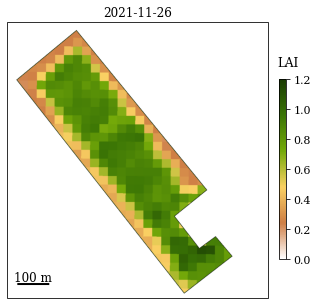

✅ Figura guardada en: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\LAI\2021-12-04_LAI1_min0.png


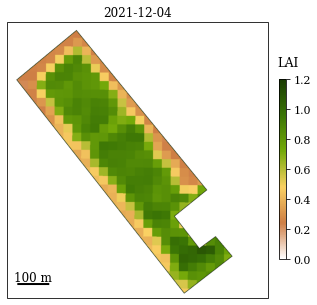

✅ Figura guardada en: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\LAI\2022-03-02_LAI1_min0.png


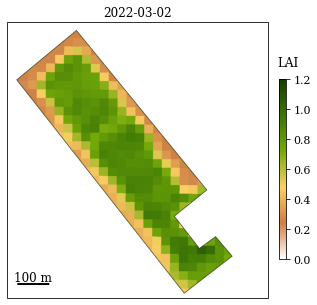

✅ Figura guardada en: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\LAI\2022-03-18_LAI1_min0.png


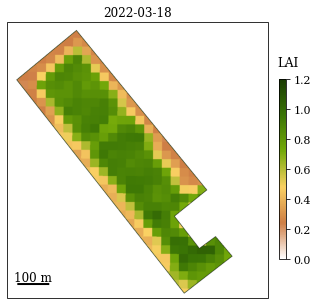

✅ Figura guardada en: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\LAI\2022-04-03_LAI1_min0.png


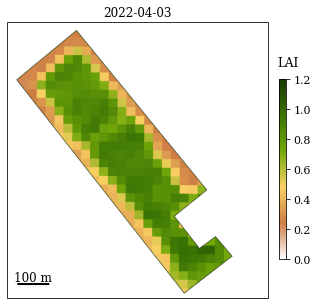

✅ Figura guardada en: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\LAI\2022-04-19_LAI1_min0.png


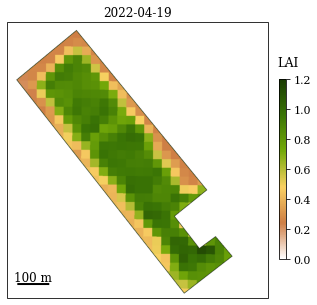

✅ Figura guardada en: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\LAI\2022-04-27_LAI1_min0.png


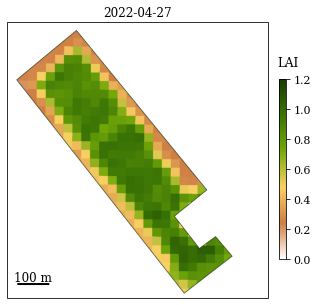

✅ Figura guardada en: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\LAI\2022-05-05_LAI1_min0.png


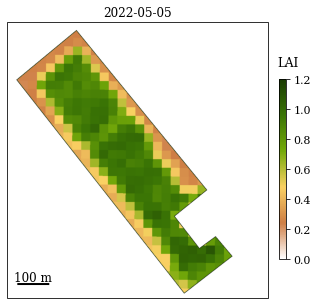

✅ Figura guardada en: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\LAI\2022-07-08_LAI1_min0.png


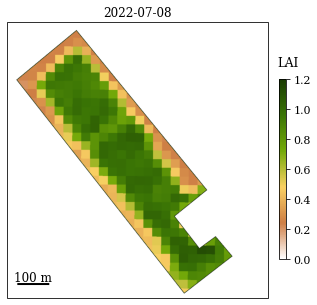

✅ Figura guardada en: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\LAI\2022-07-24_LAI1_min0.png


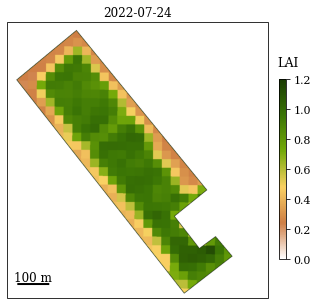

In [29]:
for n_img, img in enumerate(lista_imgprocesadas):
    img_ = img['img_productos'].select('LAI').clip(predios_agricolas)
    fecha = img['fecha']

    vis_params_lai = {
        'min': 0,
        'max': 1.2,
        'palette': ndvi_cmap
    }

    get_grafica_cartoee_color(
        img_.blend(predios_vis),
        vis_params_lai,
        title_map=f'{fecha}',
        label='LAI',
        save_fig=f'{fecha}_LAI1_min0',
        nogrid=True
    )


In [30]:
import ee, geemap
ee.Initialize()

# Paleta (usa la tuya si ya tienes ndvi_cmap definido)
# ndvi_cmap = cmp.get_palette('RdYlGn')  # por ejemplo
# vis_rgb ya lo tienes definido

vis_params_ndvi = {
    'min': -0.2,
    'max': 1.0,
    'palette': ndvi_cmap
}

vis_params_lai = {
    'min': 0.0,
    'max': 1.2,          # fija para TODAS las fechas
    'palette': ndvi_cmap
}

# 👇 Evita que geemap reinicialice EE (y toque _credentials)
Map = geemap.Map(ee_initialize=False)
Map.centerObject(predios_agricolas, 16)

# (opcional) capa base RGB fija si tienes una general
try:
    Map.addLayer(img_rgb, vis_rgb, 'img_rgb (base)')
except Exception:
    pass

for item in lista_imgprocesadas:
    fecha = item['fecha']
    prods = item['img_productos'].clip(predios_agricolas)

    # NDVI
    try:
        ndvi = prods.select('NDVI')
        Map.addLayer(ndvi, vis_params_ndvi, f'img_ndvi {fecha}')
    except Exception:
        pass

    # LAI + LAI <= 0
    try:
        lai = prods.select('LAI')
        lai_n = lai.updateMask(lai.lte(0))
        Map.addLayer(lai,   vis_params_lai, f'img_lai {fecha}')
        Map.addLayer(lai_n, {},             f'img_lai_n {fecha}')
    except Exception:
        pass

Map.addLayerControl()
Map


Map(center=[-18.18141181765202, -70.53212395232164], controls=(WidgetControl(options=['position', 'transparent…

In [31]:
# ===================================================================================================
# Selección de pixel frío
# 1. Ubica el pixel frío en el mapa y coloca un marker con la opción "draw a marker"
# 2. Una vez ubicado, correr la línea de abajo para obtener sus coordenadas [longitud, latitud]
# ===================================================================================================

Map.user_rois.geometry().coordinates().getInfo() 
# PixC [-79.784183, -6.596201]

[-70.531443, -18.181232]

In [ ]:
vis_params_ndvi = {
    'min': -0.2, # img_productos_dict['min']['NDVI'],
    'max': 1,    # img_productos_dict['max']['NDVI'],
    'palette': ndvi_cmap # cmp.get_palette('RdYlGn')
}

vis_params_lai = {
    'min': 0,  
    'max': img_productos_dict['max']['LAI'], 
    'palette': ndvi_cmap # RdYlGn_r, afmhot, turbo_r
}

img_lai  = img_productos.select('LAI')
img_lai_n = img_lai.updateMask(img_lai.lte(0))

# Mapas
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_rgb, vis_rgb, 'img_rgb')
Map.addLayer(img_ndvi, vis_params_ndvi, 'img_ndvi')
Map.addLayer(img_lai,  vis_params_lai, 'img_lai')
Map.addLayer(img_lai_n, {}, 'img_lai_n')
Map

In [27]:
# ===================================================================================================
# Selección de pixel frío
# 1. Ubica el pixel frío en el mapa y coloca un marker con la opción "draw a marker"
# 2. Una vez ubicado, correr la línea de abajo para obtener sus coordenadas [longitud, latitud]
# ===================================================================================================

Map.user_rois.geometry().coordinates().getInfo() 
# PixC [-79.784183, -6.596201]

[]

### Función `recorte_por_percentiles`

In [46]:
def recorte_por_percentiles_alb(n1, n2, img_ndvi, img_albedo, geometry, filtrado=None):
    
    """ Recortar mapas de temperatura en función de mapa NDVI para obtener pixeles candidatos.

    Parametros
    ----------
    n1, n2 : int
    img_ndvi : ee.Image
    img_ts : ee.Image
    geometry : ee.Geometry
    filtrado : str

    Retorna
    -------
    pixeles : ee.Image
        Mapa recortado (por updateMask) de pixeles candidatos.
    """

    # 1. Procesar n1
    # Para NDVI > 0, retorna el percentil n1
    perc_n1 = ee.Number(img_ndvi
                        .updateMask(img_ndvi.gte(0))
                        .reduceRegion(ee.Reducer.percentile([n1]), geometry=geometry, scale=30)
                        .values()
        )
    
    if filtrado == 'cold':
        # Pixel frío
        # Para los valores de ndvi mayores al percentil perc_n1, retornar sus temperaturas
        alb_recortado_p_n1 = img_albedo.updateMask(img_ndvi.gte(perc_n1)) # Albedo
    else: 
        # Pixel caliente
        img_ndvi = img_ndvi.clip(geometry)
        img_albedo = img_albedo.clip(geometry)
        # Para los valores de ndvi menores al percentil perc_n1, retornar sus temperaturas
        alb_recortado_p_n1 = img_albedo.updateMask(img_ndvi.lte(perc_n1))
        
    # 2. Procesar n2
    perc_n2 = ee.Number(alb_recortado_p_n1
                        .reduceRegion(ee.Reducer.percentile([n2]), geometry=geometry, scale=30)
                        .values()
        )
    
    if filtrado == 'cold':
        # Los valores más bajos de temperatura
        # Los valores más altos de albedo
        pixeles = alb_recortado_p_n1.updateMask(alb_recortado_p_n1.gte(perc_n2))
    else:
        # Los valores más altos de temperatura
        # Los valores más bajos de albedo
        pixeles = alb_recortado_p_n1.updateMask(alb_recortado_p_n1.lte(perc_n2))
            
    return pixeles

### Pixeles Fríos

Pixeles Fríos: 
Encontrar el grupo de pixeles con
- NDVI alto
- Temperatura superficial baja

Procedimiento:
- Obtener percentil n1 para imagen NDVI con valores positivos [(ee.Reducer.percentile)](https://developers.google.com/earth-engine/apidocs/ee-reducer-percentile)
- Obtener valores de NDVI > n1 
- Recortar mapa de temperatura para valores Ts < $n_2$ en función de valores de NDVI > $n_1$
- Seleccionar un pixel y anotar coordenadas

In [ ]:
# Selección de Pixel Frío - Recorte de mapas

# 0 '2022-01-13' n1: 50 n2: 10
# 1 '2022-01-29' n1: 50 n2: 10
# 2 '2022-03-10' n1: 50 n2: 5
# 3 '2022-04-03' n1: 80 n2: 10
# 4 '2022-05-05' n1: 40 n2: 10
# 5 '2022-05-21' n1: 50 n2: 10
# 6 '2022-06-14' n1: 50 n2: 5

perc_ndvi =  30  # n1: Percentil para NDVI
perc_temp =  90  # n2: Percentil para albedo

# Procesado de imagen
pixeles_frios = recorte_por_percentiles(perc_ndvi, perc_temp, 
                                            img_ndvi, img_albedo, geometry=predios_agricolas, 
                                            filtrado='cold')

# Estadisticas
pixeles_frios_stats = get_stats(pixeles_frios, predios_agricolas, 30)

# =============================================================
# Visualizar
# ============================================================= 

# 1. Inputs para gráfico con geemap
paleta = 'YlGn'#'RdYlBu'  # Rampa de color azul y rojo
# paleta = 'binary_r'  # Color negro indica el pixel más frío

vis_params_pix = {
    'min': pixeles_frios_stats['min']['albedo'],
    'max': pixeles_frios_stats['max']['albedo'],
    'palette': cmp.get_palette(paleta) #ndvi_cmap 
}

image = pixeles_frios.blend(predios_vis)

print(lista_imgprocesadas[index]['fecha'])

# 2. Visualización con geemap
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)

Map.addLayer(img_rgb, vis_rgb, 'RGB TOA')
Map.addLayer(img_tempC, vis_params_ts, 'img_ts')
Map.addLayer(img_albedo, vis_params_alb, 'img albedo')
Map.addLayer(img_ndvi, vis_params_ndvi, 'img_ndvi')
Map.addLayer(image, vis_params_pix, 'Pixeles')

# Coordenadas previamente seleccionados (Pixel Frio)
list_coords_pixf = [
    [-70.530236, -18.184916],  # 0 '2021-11-26' n1: 50 n2: 10
    [-70.530242, -18.18464],  # 1 '2022-01-29' n1: 50 n2: 10
    [-70.52963, -18.184426],  # 2 '2022-03-10' n1: 50 n2: 5
    [-70.529362, -18.184386], # 3 '2022-04-03' n1: 80 n2: 10 
    [-70.529351, -18.184365], # 4 '2022-05-05' n1: 40 n2: 10
    [-70.530242, -18.18464], # 5 '2022-05-21' n1: 50 n2: 10
    [-70.530231, -18.184926], # 6 '2022-06-14' n1: 50 n2: 5
    [-70.531079, -18.183275],
    [-70.530231, -18.184661],
    [-70.529351, -18.184386]  # 7 '2022-06-14' n1: 50 n2: 5
]

# Coordenadas previamente seleccionados (Pixel Caliente)
# Pixeles ndvi-albedo
list_coords_pixc = [
    [-70.531615, -18.180247],  # 0 '2022-01-13' n1: 50 n2: 10
    [-70.531336, -18.180563],  # 1 '2022-01-29' n1: 50 n2: 10
    [-70.531336, -18.180573],  # 2 '2022-03-10' n1: 50 n2: 5
    [-70.534726, -18.178891],  # 3 '2022-04-03' n1: 80 n2: 10
    [-70.531325, -18.180563],  # 4 '2022-05-05' n1: 40 n2: 10 
    [-70.531615, -18.180288],  # 5 '2022-01-13' n1: 50 n2: 10
    [-70.533321, -18.181368],  # 6 '2022-06-14' n1: 50 n2: 5 de aquí cambiar
    [-70.52992, -18.182469],
    [-70.532731, -18.178922],
    [-70.532151, -18.179462]    # 7 '2022-06-14' n1: 50 n2: 5                                                      

]

Map.addLayer(ee.Geometry.Point(list_coords_pixf[index]), {}, 'Pixel F')
Map.addLayer(ee.Geometry.Point(list_coords_pixc[index]), {}, 'Pixel C')

# Map.add_colorbar(vis_params_pix, orientation='vertical', label='Pixeles [°C]')
Map

2022-04-03


Map(center=[-18.18141181765202, -70.53212395232164], controls=(WidgetControl(options=['position', 'transparent…

In [48]:
pixeles_frios_stats

{'max': {'albedo': 0.22689696364727846},
 'mean': {'albedo': 0.20497358227260126},
 'median': {'albedo': 0.20703113597075887},
 'min': {'albedo': 0.16729146860605468},
 'mode': {'albedo': 0.20690324789672573},
 'stdDev': {'albedo': 0.01123824685971604}}

In [40]:
# ===================================================================================================
# Selección de pixel frío
# 1. Ubica el pixel frío en el mapa y coloca un marker con la opción "draw a marker"
# 2. Una vez ubicado, correr la línea de abajo para obtener sus coordenadas [longitud, latitud]
# ===================================================================================================

Map.user_rois.geometry().coordinates().getInfo() 
# PixC [-79.784183, -6.596201]

[-70.528471, -18.177352]

In [52]:
lista_pixeles = [[-70.529644, -18.184389],  # 0 '2021-11-26' n1: 50 n2: 10
    [-70.52963, -18.184345],  # 1 '2022-01-29' n1: 50 n2: 10
    [-70.529662, -18.184386],  # 2 '2022-03-10' n1: 50 n2: 5
    [-70.529662, -18.184355], # 3 '2022-04-03' n1: 80 n2: 10 
    [-70.52963, -18.184365], # 4 '2022-05-05' n1: 40 n2: 10
    [-70.529652, -18.184365], # 5 '2022-05-21' n1: 50 n2: 10
    [-70.529652, -18.184365]]

for pixel in lista_pixeles:
    pixf_ee_coord = ee.Geometry.Point(pixel)
    pprint(get_pixel_values(pixf_ee_coord, d2, img_productos))

{'Albedo': 0.181017340374072,
 'Elev_m': 46,
 'G': 88.77132228111144,
 'LAI': 1.0397180903920982,
 'NDVI': 0.4460341215205028,
 'R_n': 573.7649188421191,
 'SAVI': 0.2983781472851103,
 'Slope_d': 0,
 'T_sw': 0.7205212825894463,
 'Ts_c': 31.304541100536483,
 'Ts_k': 304.45454110053646,
 'cos_theta': 0.8313188938376987,
 'e_0': 0.9603971809039209}
{'Albedo': 0.181017340374072,
 'Elev_m': 46,
 'G': 88.77132228111144,
 'LAI': 1.0397180903920982,
 'NDVI': 0.4460341215205028,
 'R_n': 573.7649188421191,
 'SAVI': 0.2983781472851103,
 'Slope_d': 0,
 'T_sw': 0.7205212825894463,
 'Ts_c': 31.304541100536483,
 'Ts_k': 304.45454110053646,
 'cos_theta': 0.8313188938376987,
 'e_0': 0.9603971809039209}
{'Albedo': 0.181017340374072,
 'Elev_m': 46,
 'G': 88.77132228111144,
 'LAI': 1.0397180903920982,
 'NDVI': 0.4460341215205028,
 'R_n': 573.7649188421191,
 'SAVI': 0.2983781472851103,
 'Slope_d': 0,
 'T_sw': 0.7205212825894463,
 'Ts_c': 31.304541100536483,
 'Ts_k': 304.45454110053646,
 'cos_theta': 0.83131

In [49]:
# Coordenadas previamente seleccionados (Pixel Frio)
list_coords_pixf = [
    [-70.530236, -18.184916],  # 0 '2021-11-26' n1: 50 n2: 10
    [-70.530242, -18.18464],  # 1 '2022-01-29' n1: 50 n2: 10
    [-70.52963, -18.184426],  # 2 '2022-03-10' n1: 50 n2: 5
    [-70.529362, -18.184386], # 3 '2022-04-03' n1: 80 n2: 10 
    [-70.529351, -18.184365], # 4 '2022-05-05' n1: 40 n2: 10
    [-70.530242, -18.18464], # 5 '2022-05-21' n1: 50 n2: 10
    [-70.530231, -18.184926], # 6 '2022-06-14' n1: 50 n2: 5
    [-70.531079, -18.183275],
    [-70.530231, -18.184661],
    [-70.529351, -18.184386]  # 7 '2022-06-14' n1: 50 n2: 5
]

# Coordenadas previamente seleccionados (Pixel Caliente)
# Pixeles ndvi-albedo
list_coords_pixc = [
    [-70.531615, -18.180247],  # 0 '2022-01-13' n1: 50 n2: 10
    [-70.531336, -18.180563],  # 1 '2022-01-29' n1: 50 n2: 10
    [-70.531336, -18.180573],  # 2 '2022-03-10' n1: 50 n2: 5
    [-70.534726, -18.178891],  # 3 '2022-04-03' n1: 80 n2: 10
    [-70.531325, -18.180563],  # 4 '2022-05-05' n1: 40 n2: 10 
    [-70.531615, -18.180288],  # 5 '2022-01-13' n1: 50 n2: 10
    [-70.533321, -18.181368],  # 6 '2022-06-14' n1: 50 n2: 5 de aquí cambiar
    [-70.52992, -18.182469],
    [-70.532731, -18.178922],
    [-70.532151, -18.179462]    # 7 '2022-06-14' n1: 50 n2: 5                                                      

]

# list_coords_pixf = [
#     [-79.78527, -6.598056],  # 0 '2022-01-13' n1: 50 n2: 10
#     [-79.78472, -6.598345],  # 1 '2022-01-29' n1: 50 n2: 10
#     [-79.78445, -6.596984],  # 2 '2022-03-10' n1: 50 n2: 5
#     [-79.779022, -6.597242], # 3 '2022-04-03' n1: 80 n2: 10
#     [-79.776047, -6.597519], # 4 '2022-05-05' n1: 40 n2: 10
#     [-79.778976, -6.605092], # 5 '2022-05-21' n1: 50 n2: 10
#     [-79.778737, -6.604828], # 6 '2022-06-14' n1: 50 n2: 5
# ]

pixf_coord = list_coords_pixf[index]
pixf_ee_coord = ee.Geometry.Point(pixf_coord)

pix_c_values = get_pixel_values(pixf_ee_coord, d2, img_productos)

display(pix_c_values)

{'Albedo': 0.16729146860605468,
 'Elev_m': 46,
 'G': 81.42277994929451,
 'LAI': 1.0240725832570583,
 'NDVI': 0.43871013166232475,
 'R_n': 523.3690679075324,
 'SAVI': 0.27715249487225246,
 'Slope_d': 0.9274099469184875,
 'T_sw': 0.701813281319853,
 'Ts_c': 34.409985347329894,
 'Ts_k': 307.55998534732987,
 'cos_theta': 0.7931762036570102,
 'e_0': 0.9602407258325706}

In [50]:
pixeles_frios_stats

{'max': {'albedo': 0.22689696364727846},
 'mean': {'albedo': 0.20497358227260126},
 'median': {'albedo': 0.20703113597075887},
 'min': {'albedo': 0.16729146860605468},
 'mode': {'albedo': 0.20690324789672573},
 'stdDev': {'albedo': 0.01123824685971604}}

In [51]:
# Pixel frio
# 0 '2022-01-13' n1: 50 n2: 10
# 1 '2022-01-29' n1: 50 n2: 10
# 2 '2022-03-10' n1: 50 n2: 5
# 3 '2022-06-14' n1: 50 n2: 5

# Selección de Pixel Frío - Recorte de mapas
perc_ndvi =  30  # n1 : Percentil para NDVI
perc_temp =  10   # n2 : Percentil para temperatura

# Procesado de imagen
pixeles_f_K = recorte_por_percentiles(perc_ndvi, 
                                      perc_temp, 
                                      img_ndvi, 
                                      img_tempK, 
                                      geometry=predios_agricolas, 
                                      filtrado='cold') # [K]
pixeles_f_C = pixeles_f_K.subtract(273.15).rename('Ts_C') # [°C]
pixeles_f_stats = get_stats(pixeles_f_C, predios_agricolas, 30)

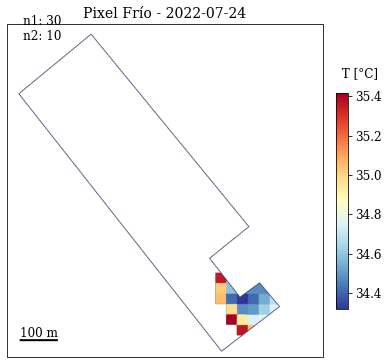

In [53]:
# 1. Inputs para gráfico con geemap
paleta = 'RdYlBu_r'  # Rampa de color azul y rojo
# paleta = 'binary_r'  # Color negro indica el pixel más frío

vis_params_pix = {
    'min': pixeles_f_stats['min']['Ts_C'],
    'max': pixeles_f_stats['max']['Ts_C'],
    'palette': cmp.get_palette(paleta)
}

image = pixeles_f_C.blend(predios_vis)
title_map = f'Pixel Frío - {fecha}'

get_grafica_cartoee_color(image, 
                          vis_params_pix, 
                          title_map=title_map,
                          text=f'n1: {perc_ndvi}\nn2: {perc_temp}',
                          nogrid=True,
                          label="  T [°C]",
                          save_fig= f'C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive/Graficos/{fecha}_Pix_F'
                          #dpi=600  # <-- 600 dpi
)

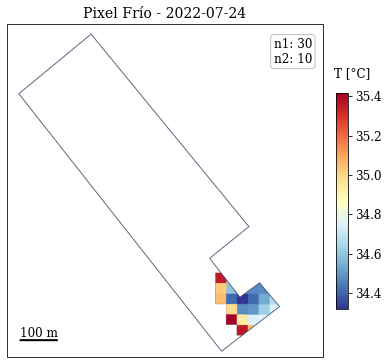

In [54]:
# =========================
# IMPORTS
# =========================
import os
import matplotlib.pyplot as plt
from geemap import cartoee

# =========================
# FUNCIÓN (manteniendo tu ubicación exacta)
# =========================
def get_grafica_cartoee_color(image, 
                              vis_params,                              
                              text=None, 
                              title_map=None,
                              label=None, 
                              save_fig=None,
                              nogrid=None):
    """Obtener gráficas con cartoee
    La variable zoom_region debe asignarse según la zona de estudio.
    Para modificaciones seguir: https://geemap.org/cartoee/#cartoee-module
    """

    # Establecer área de plot usando las coordenadas de predios_bound.coordinates().getInfo()
    extent = 0.0004
    zoom_region = [
        -70.53539711730724 - extent,   # west  - extent
        -18.185505011017327 - extent,  # south - extent
        -70.52796183246036 + extent,   # east  + extent
        -18.177618129602468 + extent   # north + extent
    ]
    
    # Establecer figsize para plot
    fig = plt.figure(figsize=(8, 6))  # Para analizar
    
    # ee.Image a plotear
    ax = cartoee.get_map(image, region=zoom_region, vis_params=vis_params)

    # Añadir grillas
    if nogrid is None:
        cartoee.add_gridlines(
            ax, interval=0.005, ytick_rotation=90,
            linestyle=":", linewidth=0.01  # Grillas invisibles
        )

    # Añadir barra de color
    if label is not None:
        cartoee.add_colorbar(
            ax, vis_params=vis_params, loc='right',
            # label=label,
            posOpts=[0.785, 0.22, 0.02, 0.5],
            tick_font_size=12
        )
        ax.text(-70.5369 + 2*extent, -18.1786, label, fontsize=12)

    # Título
    if title_map is not None:
        ax.set_title(title_map)

    # Texto n1/n2 en esquina superior derecha y un poco más abajo (coordenadas de datos)
    if text is not None:
        west, south, east, north = zoom_region
        ax.text(
            east - 0.00796,        # <-- mantiene tu ubicación horizontal
            north - 0.00035,       # <-- mantiene tu ubicación vertical
            text,
            fontsize=12,
            ha='right', va='top',
            bbox=dict(boxstyle="round,pad=0.25",
                      facecolor='white', edgecolor='0.7', alpha=0.85)
        )
        
    # Escala
    cartoee.add_scale_bar_lite(
        ax, length=100, xy=(0.9, 0.05), linewidth=2,
        fontsize=12, color="black", unit="m",
        ha="center", va="bottom"
    )
    ax.tick_params(axis='both')
    
    # Guardar gráficas
    if save_fig is not None:
        out_dir = r'C:\Users\joluh\OneDrive\Olivo\Metric_Olivo\Graficos'
        os.makedirs(out_dir, exist_ok=True)
        ruta_img = os.path.join(out_dir, save_fig + '.png')
        plt.savefig(ruta_img, bbox_inches='tight', pad_inches=.1, dpi=600)

    plt.show()

# =========================
# ENTRADAS Y LLAMADA
# =========================
paleta = 'RdYlBu_r'  # Rampa de color azul y rojo
# paleta = 'binary_r'  # Color negro indica el pixel más frío

vis_params_pix = {
    'min': pixeles_f_stats['min']['Ts_C'],
    'max': pixeles_f_stats['max']['Ts_C'],
    'palette': cmp.get_palette(paleta)
}

image = pixeles_f_C.blend(predios_vis)
title_map = f'Pixel Frío - {fecha}'
texto_badge = f'n1: {perc_ndvi}\nn2: {perc_temp}'

get_grafica_cartoee_color(
    image, 
    vis_params_pix, 
    title_map=title_map,
    text=texto_badge,
    nogrid=True,
    label="T [°C]",
    save_fig=f'{fecha}_Pix_F'   # se guardará en ...\Graficos\{fecha}_Pix_F.png a 600 dpi
)


### Pixeles Calientes

- The “hot” pixel should be located in a dry and bare agricultural field where one can
assume there is no evapotranspiration taking place.
-  It is recommended that one no use:
    - a hot desert area
    - an asphalt parking lot
    - a roof
    - a south facing mountain slope
    - or other such extremely hot areas
since the relationship between dT and Ts may not
follow the same linear relation as for agricultural and bare agricultural soils.ils.

In [55]:
# Selección de Pixel Caliente - Recorte de mapas

# 0 '2022-01-13' n1: 40 n2: 97
# 1 '2022-01-29' n1: 10 n2: 90
# 2 '2022-03-10' n1: 4  n2: 75 
# 3 '2022-04-03' n1: 10 n2: 80
# 4 '2022-05-05' n1: 25 n2: 75
# 5 '2022-05-21' n1: 30 n2: 80
# 6 '2022-06-14' n1: 10 n2: 80

perc_ndvi = 25  # n1 : Percentil para NDVI
perc_temp = 75  # n2 : Percentil para temperatura

pixeles_hot_K = recorte_por_percentiles(perc_ndvi, 
                                        perc_temp, 
                                        img_ndvi, img_tempK, 
                                        geometry=predios_agricolas) # [K]
pixeles_hot_C = pixeles_hot_K.subtract(273.15) # [°C]

pixeles_hot_stats = get_stats(pixeles_hot_C, predios_agricolas, 30)
# display(pd.DataFrame.from_dict(pixeles_hot_stats, orient='index'))

# Obtener gráfica con cartoee
paleta = 'RdYlBu_r' # RdYlBu_r o binary_r # Color negro o rojo el pixel más caliente

vis_params_pix = {
    'min': pixeles_hot_stats['min']['Ts_k'],
    'max': pixeles_hot_stats['max']['Ts_k'],
    'palette': cmp.get_palette(paleta) 
}

print(lista_imgprocesadas[index]['fecha'])
image = pixeles_hot_C.blend(predios_vis) # predios_vis, ee_RectangleVis

# Visualización
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_rgb, vis_rgb, 'RGB TOA')

Map.addLayer(img_albedo, vis_params_alb, 'albedo')
Map.addLayer(img_tempC, vis_params_ts, 'img_tempC')
Map.addLayer(img_ndvi, vis_params_ndvi, 'img_ndvi')
Map.addLayer(image, vis_params_pix, 'Pixeles C')
Map.addLayer(image, vis_params_pix, 'Pixeles C')

vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']} 

Map.addLayer(ee.Geometry.Point([-79.78527, -6.598056]), {}, 'pixel f')
Map.addLayer(ee.Geometry.Point([-79.78198, -6.602693]), {}, 'pixel c')

# Map.add_colorbar(vis_params_ts,  orientation="horizontal", label="img Ts [°C]")
Map.add_colorbar(vis_params_pix, orientation='vertical', label='Pixeles [°C]')
Map

2022-04-03


Map(center=[-18.18141181765202, -70.53212395232164], controls=(WidgetControl(options=['position', 'transparent…

In [45]:
# ===================================================================================================
# Selección de pixel caliente
# 1. Ubica el pixel caliente en el mapa y coloca un marker con la opción "draw a marker"
# 2. Una vez ubicado, correr la línea de abajo para obtener sus coordenadas [longitud, latitud]
# ===================================================================================================

Map.user_rois.geometry().coordinates().getInfo() 

[]

In [46]:
list_coords_pixc = [
    [-79.78198, -6.602693],  # 0 '2022-01-13' n1: 40 n2: 97 
    [-79.778464, -6.605114], # 1 '2022-01-29' n1: 10 n2: 90
    [-79.777924, -6.604045], # 2 '2022-03-10' n1: 4 n2: 75 
    [-79.778463, -6.603747], # 3 '2022-04-03' n1: 10 n2: 80  
    [-79.784448, -6.598642], # 4 '2022-05-05' n1: 25 n2: 75  
    [-79.785537, -6.598398], # 5 '2022-05-21' n1: 30 n2: 80  
    [-79.784729, -6.595629], # 6 '2022-06-14' n1: 10 n2: 80 
]

pixc_coord = list_coords_pixc[index]
pixc_ee_coord = ee.Geometry.Point(pixc_coord)

pix_h_values = get_pixel_values(pixc_ee_coord, d2, img_productos)
pix_h_values

{'Albedo': 0.1640379349989819,
 'Elev_m': 45,
 'G': 99.81847976825907,
 'LAI': 0,
 'NDVI': 0.13498973596658878,
 'R_n': 629.7579608224345,
 'SAVI': 0.08112945597048568,
 'Slope_d': 2.075801134109497,
 'T_sw': 0.719278266959485,
 'Ts_c': 26.066006143985874,
 'Ts_k': 299.21600614398585,
 'cos_theta': 0.8596457643822332,
 'e_0': 0.95}

In [38]:
pixeles_hot_stats

{'max': {'Ts_k': 38.827858708890574},
 'mean': {'Ts_k': 38.25778813310832},
 'median': {'Ts_k': 38.198605982689},
 'min': {'Ts_k': 37.871564151394296},
 'mode': {'Ts_k': 37.871564151394296},
 'stdDev': {'Ts_k': 0.2666560870866968}}

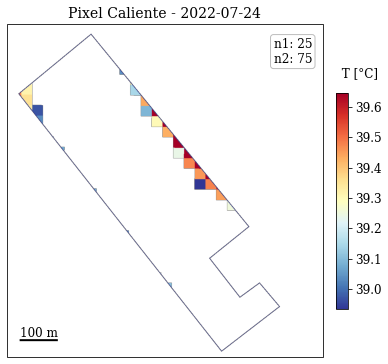

In [56]:
# Obtener gráfica con cartoee
paleta = 'RdYlBu_r' # RdYlBu_r o binary_r # Color negro o rojo el pixel más caliente

vis_params_pix_c = {
    'min': pixeles_hot_stats['min']['Ts_k'],
    'max': pixeles_hot_stats['max']['Ts_k'],
    'palette': cmp.get_palette(paleta) 
}

image = pixeles_hot_C.blend(predios_vis) 
title_map = f'Pixel Caliente - {fecha}'

get_grafica_cartoee_color(image, 
                          vis_params_pix_c, 
                          title_map=title_map,
                          text=f'n1: {perc_ndvi}\nn2: {perc_temp}',
                          nogrid=True,
                          label="  T [°C]",
                          save_fig= f'C:/Users/joluh/OneDrive/Olivo/Metric_Olivo/Graficos/{fecha}_Pix_C'
)

### Pruebas

In [ ]:
# # Selección de Pixel Frío - Recorte de mapas (temperaturas y ndvi)

# # 0 '2022-01-13' n1: 50 n2: 10
# # 1 '2022-01-29' n1: 50 n2: 10
# # 2 '2022-03-10' n1: 50 n2: 5
# # 3 '2022-04-03' n1: 80 n2: 10
# # 4 '2022-05-05' n1: 40 n2: 10
# # 5 '2022-05-21' n1: 50 n2: 10
# # 6 '2022-06-14' n1: 50 n2: 5

# perc_ndvi =  50  # n1: Percentil para NDVI
# perc_temp =  10  # n2: Percentil para temperatura

# # Procesado de imagen
# pixeles_frios_K = recorte_por_percentiles(perc_ndvi, perc_temp, 
#                                           img_ndvi, img_tempK, geometry=predios_agricolas, 
#                                           filtrado='cold') # [K]
# pixeles_frios_C = pixeles_frios_K.subtract(273.15).rename('Ts_C') # [°C]

# # Estadisticas
# pixeles_frios_stats = get_stats(pixeles_frios_C, predios_agricolas, 30)

# # =============================================================
# # Visualizar
# # ============================================================= 

# # 1. Inputs para gráfico con geemap
# paleta = 'RdYlBu_r'  # Rampa de color azul y rojo
# # paleta = 'binary_r'  # Color negro indica el pixel más frío

# vis_params_pix = {
#     'min': pixeles_frios_stats['min']['Ts_C'],
#     'max': pixeles_frios_stats['max']['Ts_C'],
#     'palette': cmp.get_palette(paleta)
# }

# image = pixeles_frios_C.blend(predios_vis)

# print(lista_imgprocesadas[index]['fecha'])

# # 2. Visualización con geemap
# Map = geemap.Map()
# Map.centerObject(predios_agricolas, 16)

# Map.addLayer(img_rgb, vis_rgb, 'RGB TOA')
# Map.addLayer(img_tempC, vis_params_ts, 'img Ts °C')
# Map.addLayer(img_ndvi, vis_params_ndvi, 'img_ndvi')
# Map.addLayer(image, vis_params_pix, 'Pixeles')

# Map.addLayer(ee.Geometry.Point([-79.778976, -6.605092]), {}, 'Pixel')

# Map.add_colorbar(vis_params_pix, orientation='vertical', label='Pixeles [°C]')
# Map

In [50]:
# Coordenadas previamente seleccionados (Pixel Frio)
list_coords_pixf = [
    [-79.78527, -6.598056],  # 0 '2022-01-13' n1: 50 n2: 10
    [-79.78472, -6.598345],  # 1 '2022-01-29' n1: 50 n2: 10
    [-79.78445, -6.596984],  # 2 '2022-03-10' n1: 50 n2: 5
    [-79.779022, -6.597242], # 3 '2022-04-03' n1: 80 n2: 10
    [-79.776047, -6.597519], # 4 '2022-05-05' n1: 40 n2: 10
    [-79.778976, -6.605092], # 5 '2022-05-21' n1: 50 n2: 10
    [-79.778737, -6.604828], # 6 '2022-06-14' n1: 50 n2: 5
]

pixf_coord = list_coords_pixf[index]
pixf_ee_coord = ee.Geometry.Point(pixf_coord)

pix_c_values = get_pixel_values(pixf_ee_coord, d2, img_productos)

display(pix_c_values)

{'Albedo': 0.11928788879851318,
 'Elev_m': 46,
 'G': 92.42170497129834,
 'LAI': 0.28349702578764563,
 'NDVI': 0.43160180390846825,
 'R_n': 705.3689216452957,
 'SAVI': 0.23416074179539104,
 'Slope_d': 2.630251407623291,
 'T_sw': 0.7408276292133484,
 'Ts_c': 18.42817530727416,
 'Ts_k': 291.57817530727414,
 'cos_theta': 0.8667525026687692,
 'e_0': 0.9528349702578764}

### Gráficas

In [102]:
index = 0 # 0 1 Enero, 2 Marzo, 3 Junio 

img_productos = lista_imgprocesadas[index]['img_productos']

fecha = lista_imgprocesadas[index]['fecha']
# img_productos.clip(predios_agricolas)

d2 = lista_imgprocesadas[index]['d2']
img_ndvi = img_productos.select('NDVI')
img_savi = img_productos.select('SAVI')
img_lai  = img_productos.select('LAI')
img_albedo = img_productos.select('albedo')
img_tempC = img_productos.select('Ts_c')
img_tempK = img_productos.select('Ts_k')
img_slope = img_productos.select('slope')

cos_theta_rel = img_productos.select('cos_theta')
t_sw = img_productos.select('t_sw')
e_0  = img_productos.select('e_0')

# Estadísticas
img_productos_dict = get_stats(img_productos, predios_agricolas, 30)
img_productos_df = pd.DataFrame.from_dict(img_productos_dict, orient='index') # .round(3)
display(img_productos_df)

vis_params_ndvi = {
    'min': -0.2, # img_productos_dict['min']['NDVI'],
    'max': 1,    # img_productos_dict['max']['NDVI'],
    'palette': ndvi_cmap # cmp.get_palette('RdYlGn')
}

vis_params_savi = {
    'min': img_productos_dict['min']['SAVI'],
    'max': img_productos_dict['max']['SAVI'],
    'palette': ndvi_cmap # cmp.get_palette('RdYlGn')
}

vis_params_alb = {
    'min': 0,
    'max': 0.25,
    'palette': cmp.get_palette('cubehelix') 
}

vis_params_ts = {
    'min': img_productos_dict['min']['Ts_c'],
    'max': img_productos_dict['max']['Ts_c'],
    'palette':cmp.get_palette('RdYlBu_r')
}

vis_params_lai = {
    'min': 0,  
    'max': img_productos_dict['max']['LAI'], 
    'palette': cmp.get_palette('cubehelix_r') # RdYlGn_r, afmhot, turbo_r
}

,LAI,NDVI,SAVI,Ts_c,Ts_k,albedo,cos_theta,cos_theta_1,e_0,e_NB,elevation,slope,t_sw
max,1.121259,0.484205,0.339354,43.237792,316.387792,0.327838,0.944783,0.903000,0.961213,0.973700,53.000000,10.366290,0.711730
mean,0.698014,0.286075,0.211533,40.170591,313.320591,0.245039,0.902640,0.902972,0.956980,0.972303,46.771127,2.854948,0.701728
median,0.793555,0.330800,0.243267,40.200004,313.350004,0.242545,0.904197,0.902973,0.957945,0.972618,47.000000,2.780288,0.701645
min,0.212608,0.058846,0.041984,36.810936,309.960936,0.197660,0.843444,0.902944,0.952126,0.970702,41.000000,0.000000,0.692406
mode,0.872807,0.367899,0.268766,39.982604,314.453534,0.242545,0.906913,0.902961,0.958827,0.972880,47.000000,1.346332,0.698296
stdDev,0.239390,0.112064,0.080992,1.344721,1.344721,0.022654,0.017021,0.000014,0.002394,0.000790,1.913741,1.607552,0.004043


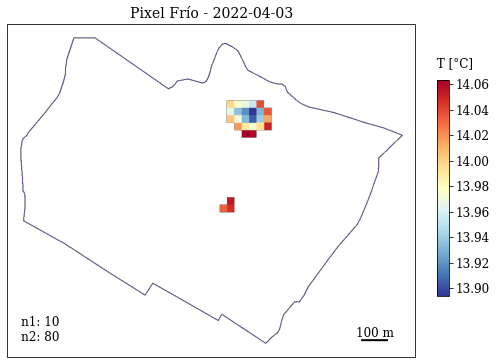

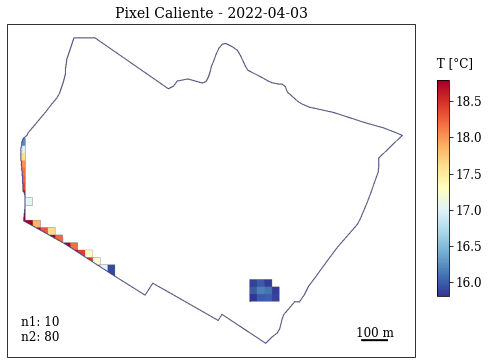

In [60]:
# Pixel frio
# 0 '2022-01-13' n1: 50 n2: 10
# 1 '2022-01-29' n1: 50 n2: 10
# 2 '2022-03-10' n1: 50 n2: 5
# 3 '2022-06-14' n1: 50 n2: 5

# Selección de Pixel Frío - Recorte de mapas
perc_ndvi =  50  # n1 : Percentil para NDVI
perc_temp =  5   # n2 : Percentil para temperatura

# Procesado de imagen
pixeles_f_K = recorte_por_percentiles(perc_ndvi, 
                                      perc_temp, 
                                      img_ndvi, 
                                      img_tempK, 
                                      geometry=predios_agricolas, 
                                      filtrado='cold') # [K]
pixeles_f_C = pixeles_f_K.subtract(273.15).rename('Ts_C') # [°C]
pixeles_f_stats = get_stats(pixeles_f_C, predios_agricolas, 30)

# Pixel caliente
# 0 '2022-01-13' n1: 40 n2: 97
# 1 '2022-01-29' n1: 50 n2: 70
# 2 '2022-03-10' n1: 4 n2: 80 
# 3 '2022-06-14' n1: 10 n2: 80

# Selección de Pixel Caliente - Recorte de mapas
perc_ndvi = 10  # n1 : Percentil para NDVI
perc_temp = 80 # n2 : Percentil para temperatura

pixeles_c_K = recorte_por_percentiles(perc_ndvi, 
                                        perc_temp, 
                                        img_ndvi, 
                                        img_tempK, 
                                        geometry=predios_agricolas) # [K]
pixeles_c_C = pixeles_c_K.subtract(273.15) # [°C]
pixeles_c_stats = get_stats(pixeles_c_C, predios_agricolas, 30)

# 1. Inputs para gráfico con geemap
path = 'D:/2025/Olivo_Tacna/METRIC/METRIC_PRUEBA/Grafico'

# Pixel Frio
paleta = 'RdYlBu_r' # Rampa de color azul y rojo
vis_params_pixf = {
    'min': pixeles_f_stats['min']['Ts_C'],
    'max': pixeles_f_stats['max']['Ts_C'],
    'palette': cmp.get_palette(paleta)
}

image = pixeles_f_C.blend(predios_vis)
title_map = f'Pixel Frío - {fecha}'

get_grafica_cartoee_color(image, 
                          vis_params_pixf, 
                          title_map=title_map,
                          text=f'n1: {perc_ndvi}\nn2: {perc_temp}',
                          nogrid=True,
                          label="  T [°C]",
                          save_fig=f'{path}/{fecha}_Pix_F'
)

# Pixel Caliente
paleta = 'RdYlBu_r' # Color rojo el pixel más caliente
vis_params_pixc = {
    'min': pixeles_c_stats['min']['Ts_k'],
    'max': pixeles_c_stats['max']['Ts_k'],
    'palette': cmp.get_palette(paleta) 
}

title_map = f'Pixel Caliente - {fecha}'
image = pixeles_c_C.blend(predios_vis)

get_grafica_cartoee_color(image, 
                          vis_params_pixc, 
                          title_map=title_map,
                          text=f'n1: {perc_ndvi}\nn2: {perc_temp}',
                          nogrid=True,
                          label="  T [°C]",
                          save_fig=f'{path}/{fecha}_Pix_C'
)